* Policy ->algo used to determine actions; neural net take in obs and select an action
* Policy Gradients -> basically using gradient descent to tweak parameters to maximize rewards
* Pick the highest predicted action with some probability to allow exploitation and exploration
* Credit assignment problem -> when an agent gets a reward, hard to know which action should get assignment. To solve, usually evaluate an action based on sum of all rewards which came after it - discounted - discounting later actions more. Discount rates are usually 0.95 or 0.99. 0.95 => 13 steps into future 1/2 as important. 69 steps with 0.99.

In [1]:
import gym
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch
from torch.distributions import Categorical
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
env = gym.make("CartPole-v0")

[2018-04-21 22:43:53,411] Making new env: CartPole-v0


## Simple Neural Net Policy

In [3]:
class NNPolicy(nn.Module):
    def __init__(self, n_inputs=4, n_hidden=4, n_outputs=2):
        super(NNPolicy, self).__init__()
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs
        
        self.hidden1 = nn.Linear(n_inputs, n_hidden)
        self.out = nn.Linear(n_hidden, n_outputs)
        
    def forward(self, x):
        output = F.elu(self.hidden1(x))
        output = self.out(output)
        return F.softmax(output, dim=1)

In [4]:
nnpolicy = NNPolicy()
optimizer = optim.Adam(nnpolicy.parameters(), lr=1e-2)

def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.empty(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + discount_rate * cumulative_rewards
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(reward, discount_rate) for reward in rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/(reward_std + np.finfo(np.float32).eps)
            for discounted_rewards in all_discounted_rewards]

def update_model(all_rewards, all_gradients, discount_rate):
    # get discounted rewards -> discount rewards which happened later more and normalize
    loss = []
    all_rewards = discount_and_normalize_rewards(all_rewards,discount_rate)
    # for every game played, sum up the total losses where you take the loss (*-1 since log_prob is ASCENT)
    # and multiply by the discounted, normalized reward. Thus, actions that lead to good rewards are applied
    # And actions that lead to be rewards (negative) are inversely applied.
    # Thus, that sum tells you how much to update based on that game
    for step in range(len(all_rewards)):
        r = torch.Tensor(all_rewards[step])
        step_loss = []
        for value in range(len(all_rewards[step])):
            step_loss.append(r[value] * all_gradients[step][value] * -1)
        loss.append(sum(step_loss))
    loss = torch.cat(loss)
    optimizer.zero_grad()
    # Take the mean of all games losses to help smooth out the learning (mini-batch)
    policy_loss = loss.mean()
    policy_loss.backward()
    optimizer.step()


def getGradients(n_iters = 100, n_max_steps=1000, n_games_per_gradient=10, discount_rate=0.95,
                render_rate=100, log_rate=100):
    n_steps = []
    for iteration in range(n_iters):
        all_rewards = []
        all_gradients = []
        if (iteration + 1) % log_rate ==0:
            print(iteration+1)
            print("Average Steps: {}".format(np.mean(n_steps)))
            print("Last Steps: {}".format(n_steps[-1]))
            print("Max Steps: {}".format(np.max(n_steps)))
            print("*****")
        for game in range(n_games_per_gradient):
            current_rewards = []
            current_gradients = []
            n_steps.append(n_max_steps)
            obs = env.reset()
            for step in range(n_max_steps):
                # get the predicted action probabilities from our nn policy
                outputs = nnpolicy(Variable(torch.from_numpy(obs).float().unsqueeze(0)))
                #select an action with these probabilities
                categorical_distribution = Categorical(outputs)
                seleted_action = categorical_distribution.sample()
                #save the loss function
                current_gradients.append(categorical_distribution.log_prob(seleted_action))
                #apply the action
                action = seleted_action.data[0]
                #save the reward
                obs, reward, done, _ = env.step(action)
                if (iteration + 1) % render_rate ==0:
                    env.render()
                current_rewards.append(reward)
                if done:
                    n_steps[-1] = step
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
        # apply saved loss functions
        update_model(all_rewards, all_gradients, discount_rate)
    print(n_steps[:10])
    print(n_steps[-10:])
    return n_steps

In [5]:
n = 150
n_steps = getGradients(n_iters = n, render_rate=n, log_rate=50)

50
Average Steps: 47.128571428571426
Last Steps: 103
Max Steps: 233
*****
100
Average Steps: 113.95050505050504
Last Steps: 169
Max Steps: 847
*****
150
Average Steps: 283.18791946308727
Last Steps: 1000
Max Steps: 1000
*****
[9, 23, 15, 10, 8, 19, 10, 11, 10, 14]
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


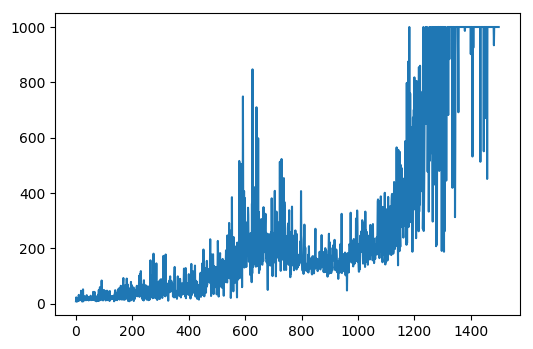

In [6]:
plt.plot(n_steps)